In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 16
epochs = 20
batch_size = 128

transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [34]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent


In [35]:
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [36]:
def train():
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, label in tqdm(train_loader):
            data = data.to(device)

            optimizer.zero_grad()
            reconstructed, _ = model(data)
            loss = criterion(reconstructed, data)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}')


In [37]:
def latent_space():
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for data, target in train_loader:
            data = data.to(device)
            _, latent = model(data)
            latent_vectors.append(latent.cpu())
            labels.append(target)

    latent_vectors = torch.cat(latent_vectors).numpy()
    labels = torch.cat(labels).numpy()
    return latent_vectors, labels

In [38]:
def visualize_reconstruction():
    model.eval()
    dataiter = iter(train_loader)
    images, _ = next(dataiter)
    images = images.to(device)

    with torch.no_grad():
        reconstructed, _ = model(images)

    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstructed')
    plt.show()

100%|██████████| 469/469 [00:06<00:00, 71.05it/s]


Epoch 1, Loss: 0.0626


100%|██████████| 469/469 [00:07<00:00, 64.96it/s]


Epoch 2, Loss: 0.0211


100%|██████████| 469/469 [00:07<00:00, 66.48it/s]


Epoch 3, Loss: 0.0172


100%|██████████| 469/469 [00:06<00:00, 68.57it/s]


Epoch 4, Loss: 0.0153


100%|██████████| 469/469 [00:07<00:00, 65.57it/s]


Epoch 5, Loss: 0.0142


100%|██████████| 469/469 [00:06<00:00, 70.92it/s]


Epoch 6, Loss: 0.0134


100%|██████████| 469/469 [00:07<00:00, 65.01it/s]


Epoch 7, Loss: 0.0128


100%|██████████| 469/469 [00:06<00:00, 70.49it/s]


Epoch 8, Loss: 0.0124


100%|██████████| 469/469 [00:07<00:00, 66.56it/s]


Epoch 9, Loss: 0.0120


100%|██████████| 469/469 [00:07<00:00, 64.92it/s]


Epoch 10, Loss: 0.0116


100%|██████████| 469/469 [00:06<00:00, 71.13it/s]


Epoch 11, Loss: 0.0114


100%|██████████| 469/469 [00:07<00:00, 65.17it/s]


Epoch 12, Loss: 0.0111


100%|██████████| 469/469 [00:06<00:00, 71.44it/s]


Epoch 13, Loss: 0.0109


100%|██████████| 469/469 [00:07<00:00, 64.95it/s]


Epoch 14, Loss: 0.0107


100%|██████████| 469/469 [00:07<00:00, 66.11it/s]


Epoch 15, Loss: 0.0105


100%|██████████| 469/469 [00:06<00:00, 68.95it/s]


Epoch 16, Loss: 0.0104


100%|██████████| 469/469 [00:07<00:00, 65.25it/s]


Epoch 17, Loss: 0.0102


100%|██████████| 469/469 [00:06<00:00, 71.05it/s]


Epoch 18, Loss: 0.0101


100%|██████████| 469/469 [00:07<00:00, 64.66it/s]


Epoch 19, Loss: 0.0100


100%|██████████| 469/469 [00:06<00:00, 68.04it/s]


Epoch 20, Loss: 0.0099


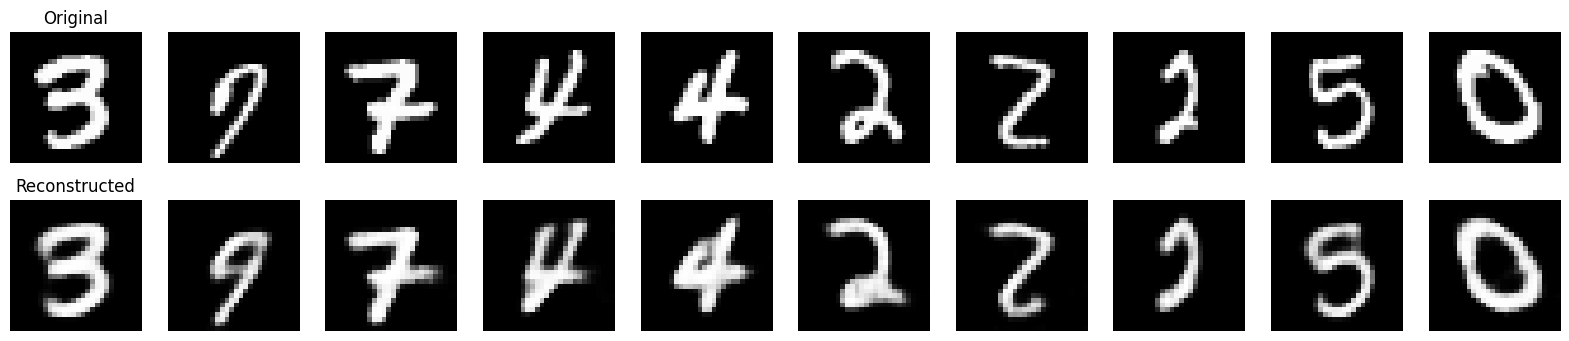

In [39]:
train()
visualize_reconstruction()

In [40]:
latent_vectors, labels = latent_space()

In [44]:
import umap
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


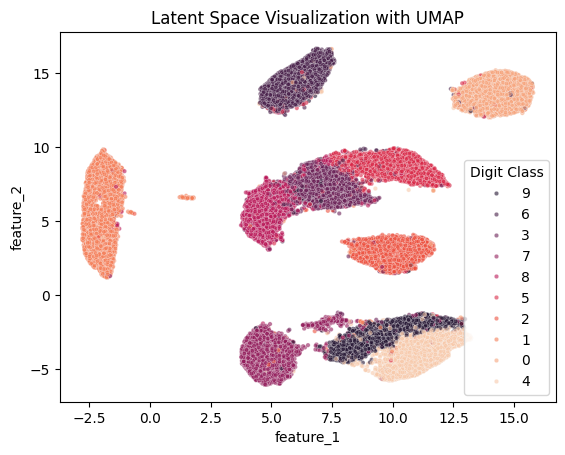

In [48]:
reducer = umap.UMAP(n_components=2, n_jobs=-1)
embedding = reducer.fit_transform(latent_vectors)

data = pd.DataFrame({
    'feature_1': embedding[:, 0],
    'feature_2': embedding[:, 1],
    'Digit': labels.astype(str)
    })

# plt.figure(figsize=(10, 8))
# sns.color_palette("rocket", as_cmap=True)
sns.scatterplot(data=data, x='feature_1', y='feature_2', hue='Digit', palette='rocket', s=10, alpha=0.6)
plt.title('Latent Space Visualization with UMAP')
plt.legend(title='Digit Class', loc='best')
plt.show()